<a href="https://colab.research.google.com/github/bhomaidan1990/Computer_Vision_Labs/blob/main/CV_Lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Course

## Lab (2)


In [1]:
##########################
# @Authors:              #
#     Belal Hmedan       #
# &   Junyi ZHONG        #
##########################
 
#========================
# Import Libraries
#========================
import os
import glob
import shutil
import re
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.patches import Rectangle
from keras.preprocessing import image
import cv2
import time
import math
import keras 
import tensorflow as tf
from keras import layers
from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

### Reproducible Code Initialization

In [2]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
# tf.random.set_seed(seed_value)
# for later versions: 
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

### 1-Download the Dataset and related files

In [3]:
#=======================
# Download the dataset
#=======================
!rm originalPics.tar.gz
!rm FDDB-folds.tgz
!rm test_db.zip
!wget http://tamaraberg.com/faceDataset/originalPics.tar.gz
!wget http://vis-www.cs.umass.edu/fddb/FDDB-folds.tgz
#-----------------------
# Test_Data
#==================
!wget http://crowley-coutaz.fr/jlc/Courses/2020/GVR.VO/test_db.zip
!mkdir test && unzip test_db.zip -d test
#-----------------------------------------------------------
# Extract the data
#==================
!rm -rf Dataset & rm -rf FDDB-folds & rm -rf sample_data & rm -rf NewDataset
t0 = time.time()
!mkdir Dataset && tar xvzf originalPics.tar.gz -C Dataset
!mkdir FDDB-folds && tar xvzf FDDB-folds.tgz -C FDDB-folds
t1 = time.time()
print('DeCompressing Time is : ',t1-t0," seconds")
# create the output dataset folder
!mkdir NewDataset

Streaming output truncated to the last 5000 lines.
2003/07/07/big/img_908.jpg
2003/07/01/big/img_250.jpg
2003/05/28/big/img_52.jpg
2002/11/06/big/img_476.jpg
2003/04/17/big/img_859.jpg
2002/09/30/big/img_903.jpg
2002/11/20/big/img_854.jpg
2003/02/23/big/img_874.jpg
2003/06/12/big/img_29.jpg
2003/03/10/big/img_518.jpg
2002/07/24/big/img_789.jpg
2003/03/10/big/img_327.jpg
2003/06/03/big/img_331.jpg
2002/09/04/big/img_13147.jpg
2002/07/23/big/img_306.jpg
2002/10/17/big/img_577.jpg
2002/08/08/big/img_981.jpg
2002/11/25/big/img_499.jpg
2002/12/18/big/img_347.jpg
2002/07/22/big/img_602.jpg
2003/07/17/big/img_341.jpg
2002/11/18/big/img_608.jpg
2003/07/02/big/img_367.jpg
2003/05/23/big/img_411.jpg
2002/12/10/big/img_717.jpg
2002/11/01/big/img_694.jpg
2002/11/26/big/img_258.jpg
2002/09/18/big/img_884.jpg
2002/10/22/big/img_1198.jpg
2003/03/10/big/img_748.jpg
2002/12/06/big/img_921.jpg
2003/07/18/big/img_30.jpg
2002/11/24/big/img_830.jpg
2002/11/01/big/img_193.jpg
2002/07/26/big/img_207.jpg
2003

### 2-Dataset Construction

**Building Indexed Data Structure for Accessing the Ground Truth easily.**

In [4]:
#========================
# Paths Initialization
#========================
# Define the Path of the original FDDB, and the output path

datasetPath = "Dataset"
outPath     = "NewDataset"
 
# Specify The required folds
 
foldsPath = "FDDB-folds/FDDB-folds/"
#=======================
foldsList  = os.listdir(foldsPath)
foldsList.sort()
folds = foldsList[1::2] # Evens, image names
annot = foldsList[0::2] # Odds, annotaions
# print(folds, '\n \n ', annot)
#------------------------
# missed backgrounds
miss = 0
#------------------------
# Get Annotation Function
#========================
def getAnnot(imgName, annotPath):
    '''
    Function to get the annotations in nd-array format for a specified image.
    
    Parameters:
    @Param: imgName : the specified image path(inside the DB).
    @Param: annotPath : the path to the txt file where the annotations stored.
    
    returns: nd-array with shape m x 5, : m num of the detected faces in the image.
             (5): max_radius | min_radius | angle | center_x | center_y
    '''
    # Initialization
    Annotaions = []
    AnnotData = []
    linIndex = -2
    numFaces = 0
 
    # Annot Search Loop
    AnnotFile = open(annotPath, "r")
    for idx, lin in enumerate(AnnotFile):
        if(re.findall(imgName,lin) != []):
            linIndex = idx
            # print(imgName, idx)
        if (idx == (linIndex + 1) ):
            numFaces = int(lin)
            # print("number of faces is: ", numFaces)
        if linIndex != -2:
            if idx in range(linIndex + 2, linIndex + 2 + numFaces):
                Annotaions.append(lin)
    # print(Annotaions)
    for Annotaion in Annotaions:
        AnnotData.append(list(filter(None, list(re.split("\s", Annotaion)))))
    AnnotData = np.array(AnnotData, dtype=float )
    AnnotData = AnnotData[...,:-1]
    # Close the txt file
    AnnotFile.close()
 
    return AnnotData
#----------------------------------------
# Build Data structure for easy indexing
# Dict[key = fold_num, value = dict[key = image name, value = nd-array]]
#========================================
DS = {}
for idx, fold in enumerate(folds):
    foldPath = os.path.join(foldsPath, fold)
    txtFile = open(foldPath, "r")
    imgDict = {}
    for lin in txtFile:
        imName = lin[:-1]
        # this to find only the string which ends with ths pattern
        imName = imName + '$'
        annotDir = os.path.join(foldsPath,annot[idx])
        # print("There",imName, annotDir)
        imgDict[lin[:-1]] = getAnnot(imName,annotDir)
        # print(imgList[0])
    # Close the txt file
    txtFile.close()
    DS["fold_{}".format(str(idx+1))] = imgDict

**function to Extract Faces and Backgrounds from the images**

In [5]:
#---------------------------------------------
# Extract faces, and Backgrounds from an image
#=============================================
def extData(imgPath, annots, foldPath, index):
    '''
    Function to Extract faces, and Backgrounds from an image.
    
    Parameters:
    @Param: imgPath : the specified image path(inside the DB).
    @Param: annots  : nd-array with shape m x 5, : m num of the detected faces in the image.
            (5): max_radius | min_radius | angle | center_x | center_y
    @Param: foldPath : the fold path where to save the extracted images.
    @Param: index : a number to start naming the faces, backgrounds from it.
    
    saves: m nd-array (m Faces), and m nd-array (m Background) in the foldPath
    '''
    fullImagePath = os.path.join(datasetPath, imgPath + '.jpg').replace('\\','/')
    img = cv2.imread(fullImagePath)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # create a mask with zeros in "faces" and bonudary
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    mask[1:-1, 1:-1] = 1
    #------------------
    # Loop the Faces
    #------------------
    for row in range(annots.shape[0]):
        # Initialize the Variables
        xc = math.floor(annots[row][3])
        yc = math.floor(annots[row][4])
        Rmax = annots[row][0] 
        Rmin =  annots[row][1]
        theta =  annots[row][2]
        # in case of rotation angles more than 45 degrees swap radius
        if(theta > 45):
            R = Rmax
            Rmax = Rmin
            Rmin = R
        # Rectangle Borders 
        st = math.sin(theta)
        st = st if st >= 0 else -st
        if(st == 0):
            st = 1
        # if(st >=(1/math.sqrt(2))):
        #     R = Rmax
        #     Rmax = Rmin
        #     Rmin = R
        # represents the top left corner of rectangle 
        x0 = math.floor(xc - Rmin * st)
        y0 = math.floor(yc - Rmax * st)
        x0 = x0 if x0 > 0 else 0
        y0 = y0 if y0 > 0 else 0
        # represents the bottom right corner of rectangle 
        x1 = math.floor(xc + Rmin * st)
        y1 = math.floor(yc + Rmax * st)
        x1 = x1 if x1 < img.shape[1] else img.shape[1]
        y1 = y1 if y1 < img.shape[0] else img.shape[0]
        # Crop the face in rectangular window
        # print("x0 = ", x0, " y0 = ", y0," x1 = ", x1," y1 = ", y1," sin(theta) = ", st)
        # print("xc = ", xc, " yc = ", yc," Rmax = ", Rmax," Rmin = ", Rmin," theta = ", theta)
        # print("image shape:", img.shape[:2])
        face = img[y0:y1, x0:x1,:]
 
        # make a directory to save the faces inside.
        foldfacedir = os.path.join(foldPath,"face")
        if(not os.path.isdir(foldfacedir)):
            os.mkdir(foldfacedir)
        facePath = os.path.join(foldfacedir, "face_{}.jpg".format(str(index+row)))
        # print(face.shape)
        cv2.imwrite(facePath, face)
        
        # Crop the face in rectangular window
        mask[y0:y1, x0:x1] = 0
        # ----- End of For Loop ----
    # once we have a map we can compute the distance of each non-face pixel to the nearest face
    dst = cv2.distanceTransform(mask, cv2.DIST_L1, 3)
 
    # pixels that are closer than 10 pixels (20//2) to a face, cannot be considered as good candidates.
    # If you allow for IoU > 0 this can be relaxed a little.
    dst[dst<10] = 0
 
    # linear indices of pixels
    idx = np.arange(np.prod(img.shape[:2]))
 
    # sample centers
    centers = []
    if(dst.sum()):
        centers = np.random.choice(idx, size=annots.shape[0], replace=False, p=dst.flatten()/dst.sum())
 
    # create the background rectangles
    backgrounds = []
    for i, c in enumerate(centers):
        r = int(np.floor(dst.flat[c]))
        r = r if (r != 10) else 11
        # sample possible R from 10 to max possible
        r = np.random.choice(range(10,r))  
        [y, x] = np.unravel_index(c, img.shape[:2])
        backgrounds.append((y-r, x-r, y+r, x+r))
    # make a directory to save the backgrounds inside.
    backgroundfolddir = os.path.join(foldPath,"background")
    if(not os.path.isdir(backgroundfolddir)):
        os.mkdir(backgroundfolddir)
    #------------------
    # Loop the Backgrounds
    #------------------
    global miss
 
    if(len(backgrounds)>= annots.shape[0]):
 
        miss -= (len(backgrounds) - annots.shape[0])
        
        for row in range(len(backgrounds)):
 
            yb0 = backgrounds[row][0]
            xb0 = backgrounds[row][1]
            yb1 = backgrounds[row][2]
            xb1 = backgrounds[row][3]
            background = img[yb0:yb1, xb0:xb1,:]
 
            # print(miss, " backgrounds missed")
 
            # Save the background to the Dataset
            backgroundPath = os.path.join(backgroundfolddir, "background_{}.jpg".format(str(index+row)))
            cv2.imwrite(backgroundPath, background)
    
    elif((len(backgrounds)< annots.shape[0]) and len(backgrounds)):
        
        miss += annots.shape[0] - len(backgrounds)
 
        for row in range(len(backgrounds)):
            yb0 = backgrounds[row][0]
            xb0 = backgrounds[row][1]
            yb1 = backgrounds[row][2]
            xb1 = backgrounds[row][3]
            background = img[yb0:yb1, xb0:xb1,:]
 
            # print(miss, " backgrounds missed")
            
            # Save the background to the Dataset
            backgroundPath = os.path.join(backgroundfolddir, "background_{}.jpg".format(str(index+row)))
            cv2.imwrite(backgroundPath, background)
 
    else:
        miss += annots.shape[0]
        print(miss, " backgrounds missed\n image: ", imgPath)
#---------------------------------------------

**Extract Faces and Backgrounds fold by fold**

In [6]:
# Create Folds files in the New Dataset
index = 0
for fld in DS:
    miss = 0
    foldOutPath = os.path.join(outPath,fld)
    if(not os.path.isdir(foldOutPath)):
        # print(outPath,'\n',foldOutPath)
        os.mkdir(foldOutPath)
    for imag in DS[fld]:
        # print(imag)
        Anno = DS[fld][imag]
        extData(imag, Anno, foldOutPath, index)
        index += Anno.shape[0]
    print(fld,'miss is: ', miss)

fold_1 miss is:  0
fold_2 miss is:  0
1  backgrounds missed
 image:  2003/01/16/big/img_627
fold_3 miss is:  1
fold_4 miss is:  0
fold_5 miss is:  0
fold_6 miss is:  0
fold_7 miss is:  0
fold_8 miss is:  0
fold_9 miss is:  0
fold_10 miss is:  0


**Split the Dataset into Train Validate Test**

In [7]:
#--------------
# Split Dataset
#==============
# we Already have the test set
!mkdir train
!mkdir train/face
!mkdir train/background
!mkdir valid
!mkdir valid/face
!mkdir valid/background
 
fileList = os.listdir("NewDataset")
fileList.sort()
for i in [x for x in range(10) if ((x != 9) and (x != 1))]:
    # print(fileList[i])
    # Train
    if(i < 7):
        subPathList = glob.glob('/content/NewDataset/'+fileList[i]+'/**/', recursive=False)
        for subPath in subPathList:
            for im in os.listdir(subPath):
                imFullPath = os.path.join(subPath, im)
                targetPath = os.path.join('/content/train',subPath.split('/')[-2]+ '/')
                # print('Train: ', targetPath)
                shutil.copy(imFullPath, targetPath)
    # Validate
    else:
        subPathList = glob.glob('/content/NewDataset/'+fileList[i]+'/**/', recursive=False)
        for subPath in subPathList:
            for im in os.listdir(subPath):
                imFullPath = os.path.join(subPath, im)
                targetPath = os.path.join('/content/valid',subPath.split('/')[-2] + '/')
                # print('Validate: ', targetPath)
                shutil.copy(imFullPath, targetPath)

### 3-MultiLayer Perceptron (MLP) Network

### 4-Input definition
Pictures are in different size, img_window set up for all images to have the same size, (8 by 8 is the minimun reconginizable face), 

while (32 x 32) will give a signifcant results compared with admissible computaion complixity, 3 color channels

In [8]:
# Define Window size (color images)
img_window = (32,32,3)
# Input shape = Window shape flattened
input_shape = np.prod(img_window)
print(input_shape)

3072


### DataGenerator

In [9]:
# Create ImagedataGenerator 
#==========================
batch_size = 256

# Train Data Generator
#---------------------
train_dir = '/content/train'
train_datagen = ImageDataGenerator(
    rescale=1./255, # rescaling factor
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')
#
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_window[:2],
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb'
    )
#---------------------
# Valid Data Generator
#---------------------
valid_dir = '/content/valid'
valid_datagen =ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')
#
validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=img_window[:2],
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb')
#---------------------
# Test Data Generator
#---------------------
test_dir = "/content/test/TESTSET/"
test_datagen = ImageDataGenerator(rescale=1./255)
#
test_generator_eval = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_window[:2],
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle = False
    )

Found 6199 images belonging to 2 classes.
Found 2072 images belonging to 2 classes.
Found 2070 images belonging to 2 classes.


### 2-MLP Network Archetecture

In [10]:
# !rm simpleMLP_model.png
# del simpleMLP
#=============================
# MLP Network 2 Hidden Layers
#=============================
K.clear_session()
simpleMLP = Sequential(
    [layers.InputLayer(input_shape=img_window, name ="InputLayer"),
     layers.Flatten(name ="FlattenLayer"), # Flattens the input, conv2D to 1 vector , which does not affect the batch size.
     layers.Dense(input_shape //2, activation="relu", name ="HLayer1"),
     #  layers.Dropout(0.2),
     layers.Dense(input_shape //2, activation="relu", name ="HLayer2"),
     #  layers.Dropout(0.1),
     layers.Dense(input_shape //2, activation="relu", name ="HLayer3"),
     layers.Dropout(0.1),
     layers.Dense(1,activation="sigmoid", name ="OutputLayer"),
     ]
)
# After model is "built" call its summary() menthod to display its contents
simpleMLP.summary()
# keras.utils.plot_model(simpleMLP, "simpleMLP_model.png", show_shapes=True)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FlattenLayer (Flatten)       (None, 3072)              0         
_________________________________________________________________
HLayer1 (Dense)              (None, 1536)              4720128   
_________________________________________________________________
HLayer2 (Dense)              (None, 1536)              2360832   
_________________________________________________________________
HLayer3 (Dense)              (None, 1536)              2360832   
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 1537      
Total params: 9,443,329
Trainable params: 9,443,329
Non-trainable params: 0
______________________________________________

### MLP Initialization

In [11]:
#=================
# Initialization
#=================
# Size of the batches of data, adjust it depends on RAM

epochs = 100

# Adaptitve Learning Rate
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=10000,
    decay_rate=0.9)

# lr_schedule = 1e-3

# decay_rate = lr_schedule / epochs
#----------------------------------------------------
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
# optimizer = keras.optimizers.SGD(lr = lr_schedule, momentum = 0.003, decay=decay_rate, nesterov=False)
# optimizer = keras.optimizers.RMSprop(lr = lr_schedule)

# Compile MLP model with 3 arguments: loss function, optimizer, and metrics function to judge model performance
simpleMLP.compile(loss="binary_crossentropy",optimizer= optimizer,metrics=["binary_accuracy"]) 
# simpleMLP.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['acc'])

### Model training

In [12]:
# Remove any old model with same name
# !rm -rf MLPmodel.h1
# !rm MLPmodel_History.npy

#======================
# Train the MLP model
#======================
#-----------------------------------------------------------------------
trainSetCount = sum([len(files) for r, d, files in os.walk(train_dir)])
validSetCount = sum([len(files) for r, d, files in os.walk(valid_dir)])
#-----------------------------------------------------------------------
# Model Checkpoint
Callbacks = [ keras.callbacks.EarlyStopping(patience=4,monitor='val_loss'),
             keras.callbacks.ModelCheckpoint('MLPmodel_Best.h5',verbose=1, save_best_only=True)]
# Fitting
history = simpleMLP.fit(
    train_generator, 
    steps_per_epoch= trainSetCount // batch_size,
    epochs= epochs, 
    validation_data=validation_generator,
    validation_steps=  validSetCount // batch_size,
    verbose=1,
    callbacks = Callbacks)
#==============
# Save the Model
#============== 
# simpleMLP.save('MLPmodel.h5')
# simpleMLP = load_model('MLPmodel.h5')
#==============
# Save History
#==============
# np.save('MLPmodel_History.npy',history.history)
# history=np.load('MLPmodel_History.npy',allow_pickle='TRUE').item()

Epoch 1/100
24/24 [==============================] - ETA: 0s - loss: 0.6150 - binary_accuracy: 0.7227
Epoch 00001: val_loss improved from inf to 0.54482, saving model to MLPmodel_Best.h5
24/24 [==============================] - 13s 534ms/step - loss: 0.6150 - binary_accuracy: 0.7227 - val_loss: 0.5448 - val_binary_accuracy: 0.7959
Epoch 2/100
24/24 [==============================] - ETA: 0s - loss: 0.4957 - binary_accuracy: 0.8142
Epoch 00002: val_loss improved from 0.54482 to 0.46056, saving model to MLPmodel_Best.h5
24/24 [==============================] - 13s 523ms/step - loss: 0.4957 - binary_accuracy: 0.8142 - val_loss: 0.4606 - val_binary_accuracy: 0.8193
Epoch 3/100
24/24 [==============================] - ETA: 0s - loss: 0.4267 - binary_accuracy: 0.8321
Epoch 00003: val_loss improved from 0.46056 to 0.41349, saving model to MLPmodel_Best.h5
24/24 [==============================] - 12s 511ms/step - loss: 0.4267 - binary_accuracy: 0.8321 - val_loss: 0.4135 - val_binary_accuracy: 

### Data Visualization

**Visualize Training curves**

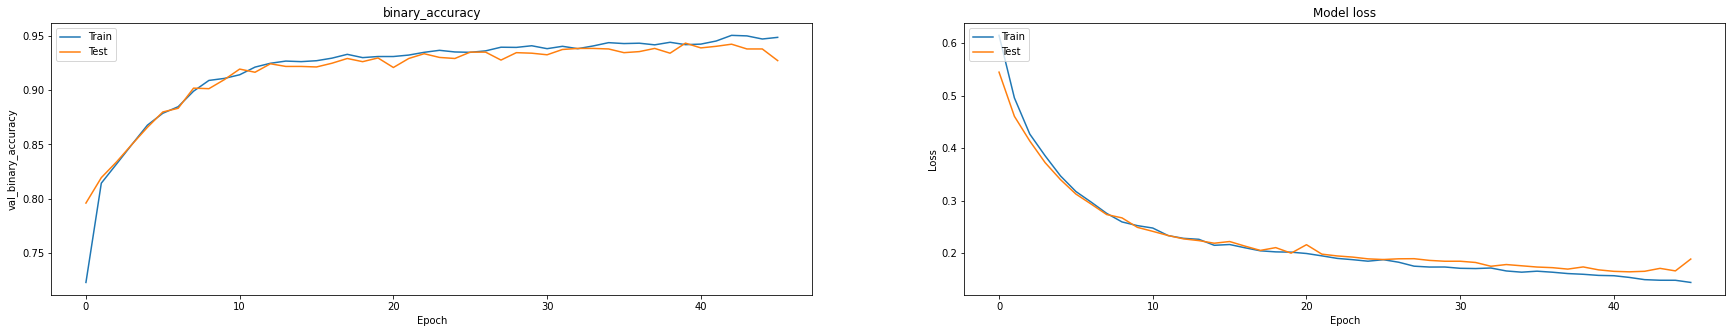

In [20]:
#=================================
"""### Visualize fitting curve""" 
#================================= 
# for key in history.history:
#     print(key, history.history[key])
plt.figure(figsize=(30, 5), num = 'Metrics')
plt.subplot(121)
plt.plot(history.history['binary_accuracy'])# binary_accuracy
plt.plot(history.history['val_binary_accuracy'])# val_binary_accuracy
plt.title('binary_accuracy')
plt.ylabel('val_binary_accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

### 3-Evaluate the Model using Standard Dataset

In [21]:
#================
# Evaluate Model
#================
simplMLP = keras.models.load_model('./MLPmodel_Best.h5')
score = simpleMLP.evaluate(test_generator_eval)
print('Test loss:', score[0])
print('Test accuracy', score[1])
#---------------------------------------

9/9 [==============================] - 1s 140ms/step - loss: 0.1643 - binary_accuracy: 0.9415
Test loss: 0.16433662176132202
Test accuracy 0.9415459036827087


### Prediction

In [22]:
#================
# Predict Model
#================
prediction = simpleMLP.predict(test_generator_eval)
#-----------------------------------------

### Visualize Prediction

Total number of batches = 9


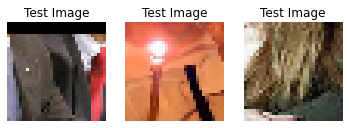

In [23]:
#===================================
"""### Visualize the Results"""
#===================================
print('Total number of batches = {}'.format(len(test_generator_eval)))
for n, i in enumerate(test_generator_eval):
    if n >= 1:
        break
    batch_data = i[0]
# print(batch_data[2])

plt.figure(num='Binary Classification')

plt.subplot('131')
plt.imshow(batch_data[0])
plt.title('Test Image')
plt.axis('off')

plt.subplot('132')
plt.imshow(batch_data[1])
plt.title('Test Image')
plt.axis('off')

plt.subplot('133')
plt.imshow(batch_data[2])
plt.title('Test Image')
plt.axis('off')

plt.show()

## 4- Metrics

### ROC

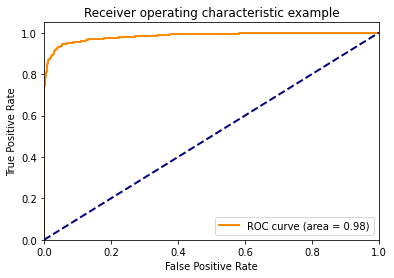

In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds  = roc_curve(test_generator_eval.classes, prediction)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# # Sensitivity
# recall = tpr

# # Specificity
# specificity = 1 - fpr


### Other Metrics

In [25]:
def precision_func(TP, FP):
    return (TP/(TP+FP))

def recall_func(TP, FN):
    return(TP/(TP+FN))

def accuracy_func(y_pred, y_label):
    return ((y_label.shape - np.sum(np.bitwise_xor(y_label, y_pred))) / y_label.shape).item()

def F1_Score_func(Precision, Recall):
    return (2*Precision*Recall)/(Precision+Recall)

def perf_measure(y_pred, y_label):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y_label[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_label[i]!=y_pred[i]:
           FP += 1
        if y_label[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_label[i]!=y_pred[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [26]:
# from sklearn.metrics import precision_recall_fscore_support

# Threshold Prediction
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

prediction[prediction< optimal_threshold] = 0
prediction[prediction>= optimal_threshold] = 1
prediction = (prediction.ravel()).astype(int)
# Get Y_GroundTruth
y_label = (np.expand_dims(test_generator_eval.classes, axis=1).ravel()).astype(int)

# Get Metrics
# Metrics = precision_recall_fscore_support(y_True, prediction)
# ----------------------------
Accuracy = accuracy_func(prediction, y_label)

(tp, fp, tn, fn) = perf_measure(prediction, y_label)
# Precision = np.min(Metrics[0])
Precision = precision_func(tp, fp)

# Recall = np.min(Metrics[1])
Recall = recall_func(tp, fn)

F1_Score = F1_Score_func(Precision, Recall)
# ----------------------------
print("Accuracy= ", Accuracy,"\nPrecision= ", Precision, "\nRecall= ", Recall, "\nF1_Score= ", F1_Score)

Threshold value is: 0.36802715
Accuracy=  0.9449275362318841 
Precision=  0.9457889641819942 
Recall=  0.9439613526570049 
F1_Score=  0.9448742746615088
